In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings
import wandb

warnings.filterwarnings('ignore')

In [2]:
class TransformationType:
    TORCHVISION = "torchvision"
    ALB = "albumentations"

class Models:
    RESNET34 = "resnet34"
    RESNET50 = "resnet50"
    RESNEXT50 = "resnext50_32x4d"
    EFFNET_B4 = "tf_efficientnet_b4_ns"

class ImgStats:
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]    

class WandbConfig:
    WANDB_KEY = ""
    WANDB_RUN_NAME = "melspec_256by313_effnet_run1"
    WANDB_PROJECT = "Pog_MusicClf_Resnext"
    USE_WANDB = False    

class SchedulerConfig:
    SCHEDULER_PATIENCE = 4
    SCHEDULER = 'CosineAnnealingWarmRestarts'
    T_0 = 10 # for CosineAnnealingWarmRestarts
    MIN_LR = 5e-7 # for CosineAnnealingWarmRestarts
    MAX_LR = 1e-2
    STEPS_PER_EPOCH = 0

# CONSTANTS
class Config:
    # whether to use mel spectrograms generated using audio augmentations ( multiple mel spec for one audio)
    USE_MEL_SPEC_AUG = True
    RUNTIME = "LOCAL"
    RESUME_FROM_CHKPT = None
    NUM_CLASSES = 5
    BATCH_SIZE = 32
    NUM_FOLDS = 5
    UNFREEZE_EPOCH_NO = 1
    NUM_EPOCHS = 2
    NUM_WORKERS = mp.cpu_count()
    INPUT_IMAGE_SIZE = (128,128)
    IMG_MEAN = ImgStats.IMAGENET_MEAN
    IMG_STD = ImgStats.IMAGENET_STD
    FAST_DEV_RUN = False
    PRECISION = 16    
    PATIENCE = 10    
    SUBSET_ROWS_FRAC = 0.05
    TRAIN_ON_SUBSET = True
    RANDOM_SEED = 42
    MODEL_TO_USE = Models.EFFNET_B4
    PRETRAINED = True        
    FIND_LR = False
    WEIGHT_DECAY = 1e-6
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
    # model hyperparameters
    MODEL_PARAMS = {    
        "drop_out": 0.25,
        "lr": 1e-4
    }

In [3]:
if Config.RUNTIME == "COLAB":
    Config.DATA_ROOT_FOLDER = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/"
    Config.IMG_ROOT_FOLDER = "/content/kaggle/processed_train/mel_spec/"
elif Config.RUNTIME == "KAGGLE":
    Config.DATA_ROOT_FOLDER = "/content/gdrive/MyDrive/Kaggle/Pog_Music_Classification/data/"
    Config.IMG_ROOT_FOLDER = "/content/kaggle/processed_train/mel_spec/"
else:
    Config.DATA_ROOT_FOLDER = "./data/"
    Config.IMG_ROOT_FOLDER = "./data/processed_train_aug/mel_spec/"

In [4]:
def config_to_dict(cfg):
    # dir is an inbuilt python function that returns the list of attributes and methods of any object
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [12]:
# split the training dataframe into kfolds for cross validation. We do this before any processing is done
# on the data. We use stratified group kfold if the target distribution is unbalanced and multiple records belong to
# a single group (song_id). To prevent data leakage we need to ensure all records of a group are assigned to one fold only
# i.e. there is no leakage between train and validation sets
def strat_group_kfold_dataframe(df, target_col_name, num_folds=Config.NUM_FOLDS):
    # we create a new column called kfold and fill it with -1
    df["kfold"] = -1
    # randomize of shuffle the rows of dataframe before splitting is done
    df = df.sample(frac=1, random_state=Config.RANDOM_SEED).reset_index(drop=True)
    # get the target data
    y = df[target_col_name].values
    groups = df.song_id.values
    skf = model_selection.StratifiedGroupKFold(n_splits=num_folds, shuffle=True, random_state=Config.RANDOM_SEED)
    for fold, (train_index, val_index) in enumerate(skf.split(X=df, y=y, groups=groups)):
        df.loc[val_index, "kfold"] = fold    
    return df     

if Config.USE_MEL_SPEC_AUG:
    df_train = pd.read_csv(Config.DATA_ROOT_FOLDER + "df_train_aug.csv")
else:
    df_train = pd.read_csv(Config.DATA_ROOT_FOLDER + "train.csv")
    # filter out records without any corresponding mel spectrogram image
    df_train["mspec_exists"] = df_train.filename.map(
        lambda fp: os.path.exists(Config.IMG_ROOT_FOLDER + fp.split(".")[0] + ".jpg")
    )
    df_train = df_train[df_train.mspec_exists]
df_train = strat_group_kfold_dataframe(df_train, target_col_name="genre_id")
df_train.head()

,Unnamed: 0,song_id,filename,filepath,genre_id,genre,file_exists,mel_spec,kfold
0,1318,17566,017566.ogg,train/017566.ogg,0,Electronic,True,017566_3.jpg,1
1,41188,5108,005108.ogg,train/005108.ogg,1,Rock,True,005108_1.jpg,2
2,10154,13172,013172.ogg,train/013172.ogg,8,Pop,True,013172_3.jpg,4
3,69851,13412,013412.ogg,train/013412.ogg,3,Experimental,True,013412_3.jpg,4
4,13325,5051,005051.ogg,train/005051.ogg,1,Rock,True,005051_4.jpg,1


In [17]:
df_train.groupby(["song_id", "kfold"], as_index=False)["mel_spec"].count()

,song_id,kfold,mel_spec
0,0,2,5
1,1,1,5
2,2,2,5
3,4,3,5
4,5,4,5
...,...,...,...
19904,24995,1,5
19905,24996,0,5
19906,24997,4,5
19907,24998,4,5


In [ ]:
Config.NUM_CLASSES = len(df_train.genre_id.unique())

In [ ]:
# A dataset contains the logic to fetch, load and if required transform data to bring it to a format
# that can be used by dataloaders for training. Image size is (128, 385, 3)
class AudioMelSpecImgDataset(Dataset):
    def __init__(self, df, file_name_col, target_col, img_root_folder, transform=None, target_transform=None):
        self.df = df
        self.file_name_col = file_name_col
        self.target_col = target_col
        self.img_root_folder = img_root_folder
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        if Config.USE_MEL_SPEC_AUG:
            mel_spec_img = self.df.loc[index, self.file_name_col]
            img_path = self.img_root_folder + mel_spec_img
        else:            
            file_name_noext = self.df.loc[index, self.file_name_col].split(".")[0]        
            img_path = self.img_root_folder + "/" + file_name_noext + ".jpg"        
        img = Image.open(img_path)
        img_arr = np.array(img)
        img_label = self.df.loc[index, self.target_col]
        if self.transform is not None:
            augmented = self.transform(image=img_arr)
            img_tfmd = augmented["image"]
            #img_tfmd = self.transform(img)            
        if self.target_transform is not None:
            img_label = self.target_transform(img_label)
        #song_id = self.df.loc[index, "song_id"] 
        return index, img_tfmd, img_label

    def __len__(self):
        return len(self.df)

In [ ]:
# from torchvision.transforms import ToTensor, RandomResizedCrop, ToPILImage

# train_transform = transforms.Compose([
#         #ToPILImage(),
#         RandomResizedCrop(size=(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1])),                
#         ToTensor()
# ])

# val_transform = transforms.Compose([
#         #ToPILImage(),
#         RandomResizedCrop(size=(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1])),        
#         ToTensor()        
# ])

In [ ]:
from albumentations.pytorch import ToTensorV2

train_transform = alb.Compose([
        alb.RandomResizedCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),        
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5),
        alb.augmentations.transforms.JpegCompression(p=0.5),
        alb.augmentations.transforms.ImageCompression(
            p=0.5, 
            compression_type=alb.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP
        ),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()
])

val_transform = alb.Compose([
        alb.CenterCrop(Config.INPUT_IMAGE_SIZE[0], Config.INPUT_IMAGE_SIZE[1]),
        alb.Normalize(mean=Config.IMG_MEAN, std=Config.IMG_STD),
        ToTensorV2()        
])

In [ ]:
def get_fold_dls(fold, df_imgs, img_root_folder):
    df_train = df_imgs[df_imgs["kfold"] != fold].reset_index(drop=True)
    df_val = df_imgs[df_imgs["kfold"] == fold].reset_index(drop=True)    
    ds_train = AudioMelSpecImgDataset(
        df_train, 
        file_name_col="mel_spec",
        target_col="genre_id",
        img_root_folder=img_root_folder,
        transform=train_transform,
        target_transform=torch.as_tensor
    )
    ds_val = AudioMelSpecImgDataset(
        df_val, 
        file_name_col="mel_spec",
        target_col="genre_id",
        img_root_folder=img_root_folder,
        transform=val_transform,
        target_transform=torch.as_tensor
    )        
    dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS)    
    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers=Config.NUM_WORKERS)
    return dl_train, dl_val, ds_train, ds_val

In [ ]:
# display images along with their labels from a batch where images are in form of numpy arrays 
# if predictions are provided along with labels, these are displayed too
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        id, img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
        if isinstance(lb, torch.Tensor):
            # extract the label from label tensor
            lb = lb.item()            
        title = f"Actual: {lb}"
        if predict_arr: 
            title += f", Pred: {predict_arr[img_index]}"        
        ax.set_title(title)  

In [ ]:
# img_path = "./data/processed_train/mel_spec/000001.jpg"
# img = Image.open(img_path)
# print(type(img))
# img_arr = np.array(img)
# img_arr = np.stack([img_arr]*3, axis=-1)
# plt.imshow(img)
# print(img_arr.shape)

In [ ]:
# print(img_arr.shape)
# img = transforms.ToPILImage()(img_arr)
# print(type(img))
# img_tfmd = val_transform(img)
# img_np = img_tfmd.detach().numpy()
# if isinstance(img_np, np.ndarray):
#     # the image data has RGB channels at dim 0, the shape of 3, 64, 64 needs to be 64, 64, 3 for display            
#     img_np = img_np.transpose(1, 2, 0)
#     plt.imshow(img_np)
#     print(img_np.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


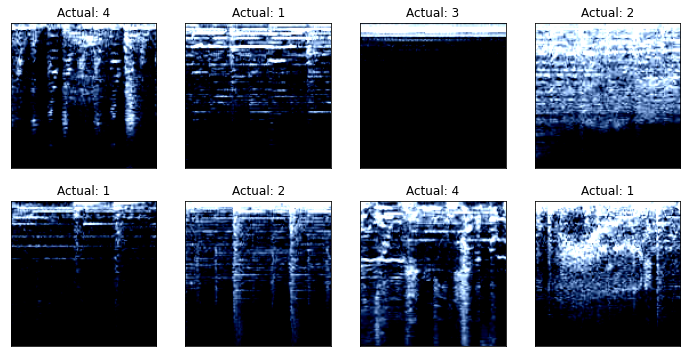

In [ ]:
dl_train, dl_val, ds_train, ds_val = get_fold_dls(0, df_train, Config.IMG_ROOT_FOLDER)
show_batch(ds_val, 8, 2, 4)

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.WEIGHT_DECAY
        )
    interval = "epoch"
    if SchedulerConfig.SCHEDULER == "CosineAnnealingWarmRestarts":
        lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=SchedulerConfig.T_0, 
                            T_mult=1, 
                            eta_min=SchedulerConfig.MIN_LR, 
                            last_epoch=-1
                        )
    elif SchedulerConfig.SCHEDULER == "OneCycleLR":
        lr_scheduler = OneCycleLR(
            optimizer=model_optimizer,
            max_lr=SchedulerConfig.MAX_LR,
            epochs=Config.NUM_EPOCHS,
            steps_per_epoch=SchedulerConfig.STEPS_PER_EPOCH,
            verbose=True
        )
        interval = "step"
    elif SchedulerConfig.SCHEDULER == "CosineAnnealingLR":
        lr_scheduler = CosineAnnealingLR(model_optimizer, eta_min=SchedulerConfig.MIN_LR, T_max=Config.NUM_EPOCHS)
    else:
        # ReduceLROnPlateau throws an error is parameters are filtered, 
        # refer: https://github.com/PyTorchLightning/pytorch-lightning/issues/8720
        model_optimizer = torch.optim.Adam(
            params, 
            lr=lr,
            weight_decay=Config.WEIGHT_DECAY
        )
        lr_scheduler = ReduceLROnPlateau(
                            model_optimizer, 
                            mode="min",                                                                
                            factor=0.1,
                            patience=SchedulerConfig.SCHEDULER_PATIENCE,
                            min_lr=SchedulerConfig.MIN_LR,                                
                            verbose=True
                        )   
    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [ ]:
import torchvision.models as models
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm

class MusicClfLitModel(pl.LightningModule):
    def __init__(self, num_classes, hparams, model_to_use):
        super().__init__()
        self.save_hyperparameters()
        self.lr = hparams["lr"]
        self.num_classes = num_classes              
        self.backbone, self.classifier = self.get_backbone_classifier(model_to_use, hparams["drop_out"], num_classes) 

    @staticmethod
    def get_backbone_classifier(model_to_use, drop_out, num_classes):
        pt_model = timm.create_model(model_to_use, pretrained=Config.PRETRAINED)
        backbone = None
        classifier = None
        if model_to_use in [Models.RESNET34, Models.RESNET50, Models.RESNEXT50]:            
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.fc.in_features
            classifier = nn.Sequential(
                nn.Dropout(drop_out),
                nn.Linear(in_features, num_classes)
            )
        if model_to_use in [Models.EFFNET_B4]:
            backbone = nn.Sequential(*list(pt_model.children())[:-1])
            in_features = pt_model.classifier.in_features
            classifier = nn.Linear(in_features, num_classes)
                    
        return backbone, classifier

    def forward(self, x):
        features = self.backbone(x)
        features = torch.flatten(features, 1)                
        x = self.classifier(features)
        return x

    def configure_optimizers(self):
        return get_optimizer(lr=self.lr, params=self.parameters())

    def training_step(self, batch, batch_idx):
        id, X, y = batch
        y_pred = self(X)
        loss = cross_entropy(y_pred, y)
        train_f1 = torchmetrics.functional.f1(preds=y_pred, target=y, num_classes=self.num_classes, average="micro")
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("train_f1", train_f1, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        id, X, y = batch
        y_pred = self(X)
        val_loss = cross_entropy(y_pred, y)
        current_lr = self.trainer.optimizers[0].param_groups[0]['lr']
        val_f1 = torchmetrics.functional.f1(preds=y_pred, target=y, num_classes=self.num_classes, average="micro")
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("val_f1", val_f1, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.log("cur_lr", current_lr, prog_bar=True, on_step=True, on_epoch=True, logger=True)
        return {"loss": val_loss, "val_f1": val_f1, "cur_lr": current_lr}

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

# For results reproducibility 
# sets seeds for numpy, torch, python.random and PYTHONHASHSEED.
pl.seed_everything(Config.RANDOM_SEED, workers=True)

Global seed set to 42


42

In [ ]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import Callback

class MetricsAggCallback(Callback):
    def __init__(self, metric_to_monitor, mode):
        self.metric_to_monitor = metric_to_monitor
        self.metrics = []        
        self.best_metric = None
        self.mode = mode
        self.best_metric_epoch = None
        self.val_epoch_num = 0

    def on_validation_epoch_end(self, trainer: Trainer, pl_module: LightningModule):
        self.val_epoch_num += 1
        metric_value = trainer.callback_metrics[self.metric_to_monitor].cpu().detach().item()
        val_loss = trainer.callback_metrics["val_loss"].cpu().detach().item()
        current_lr = trainer.callback_metrics["cur_lr"].cpu().detach().item()
        print(f"epoch = {self.val_epoch_num} => metric {self.metric_to_monitor} = {metric_value}, " \
              f"val_loss={val_loss}, lr={current_lr}")
        self.metrics.append(metric_value)
        if self.mode == "max":
            self.best_metric = max(self.metrics)
            self.best_metric_epoch = self.metrics.index(self.best_metric)         

In [ ]:
# from kaggle_secrets import UserSecretsClient

# def get_wandb_key():
#     user_secrets = UserSecretsClient()
#     wandb_secret = user_secrets.get_secret("wandb")
#     return user_secrets

In [ ]:
def get_wandb_logger():
    logger = None
    if WandbConfig.USE_WANDB:
        if Config.RUNTIME == "KAGGLE":
            pass
            #wandb_login()
        else:
            wandb.login(key=WandbConfig.WANDB_KEY)
        config_dict = config_to_dict(Config)
        schd_config_dict = config_to_dict(SchedulerConfig)
        merged_config_dict = {**config_dict, **schd_config_dict}
        logger = WandbLogger(
            name=WandbConfig.WANDB_RUN_NAME + f"_fold{fold}", 
            project=WandbConfig.WANDB_PROJECT,
            config=merged_config_dict,
            group=Config.MODEL_TO_USE
        )
    return logger

In [ ]:
from pytorch_lightning.loggers import WandbLogger

def run_training(fold, dl_train, dl_val, fold_loss, fold_f1):
    try:
        fold_str = f"fold{fold}"
        print(f"Running training for {fold_str}")
        logger = None
        val_loss_chkpt = "best_model_{epoch}_{val_loss:.4f}"
        val_f1_chkpt = "best_model_{epoch}_{val_f1:.4f}"      
        multiplicative = lambda epoch: 1.5
        backbone_finetuning = BackboneFinetuning(Config.UNFREEZE_EPOCH_NO, multiplicative, verbose=True)
        early_stopping_callback = EarlyStopping(monitor="val_loss", patience=Config.PATIENCE, mode="min", verbose=True)        
        if fold is not None:       
            val_loss_chkpt = fold_str + "_" + Config.MODEL_TO_USE + "_" + val_loss_chkpt
            val_f1_chkpt = fold_str + "_" + Config.MODEL_TO_USE + "_" + val_f1_chkpt
             
        audio_model = MusicClfLitModel(
            num_classes=Config.NUM_CLASSES, 
            hparams=Config.MODEL_PARAMS,        
            model_to_use=Config.MODEL_TO_USE
        )
        logger = get_wandb_logger()
        print("Instantiated wandb logger")    
        val_loss_chkpt_callback = ModelCheckpoint(dirpath=Config.DATA_ROOT_FOLDER+"model", verbose=True, 
                                                  monitor="val_loss", mode="min", filename=val_loss_chkpt)
        val_f1_chkpt_callback = ModelCheckpoint(dirpath=Config.DATA_ROOT_FOLDER+"model", verbose=True, 
                                                  monitor="val_f1", mode="max", filename=val_f1_chkpt)
        acc_chkpt_callback = MetricsAggCallback(metric_to_monitor="val_f1", mode="max")
        callbacks_to_use = [val_loss_chkpt_callback, val_f1_chkpt_callback, acc_chkpt_callback, early_stopping_callback]
        if Config.RESUME_FROM_CHKPT is not None:
            resume_from_checkpoint = Config.RESUME_FROM_CHKPT
        else:
            resume_from_checkpoint = None
        if Config.PRETRAINED:
            callbacks_to_use.append(backbone_finetuning)
        trainer = pl.Trainer(
            gpus=1,
            # For results reproducibility 
            deterministic=True,
            auto_select_gpus=True,
            progress_bar_refresh_rate=20,
            max_epochs=Config.NUM_EPOCHS,
            logger=logger,
            auto_lr_find=True,    
            precision=Config.PRECISION,    
            weights_summary=None, 
            fast_dev_run=Config.FAST_DEV_RUN,
            resume_from_checkpoint=resume_from_checkpoint,                   
            callbacks=callbacks_to_use
        )
        if Config.FIND_LR:
            trainer.tune(model=audio_model, train_dataloaders=dl_train)
            print(f"Learning rate using trainer.tune = {audio_model.lr}")
        print("Running trainer.fit")
        trainer.fit(audio_model, train_dataloaders=dl_train, val_dataloaders=dl_val)                
        if not Config.FAST_DEV_RUN:
            fold_loss.append((val_loss_chkpt_callback.best_model_score.cpu().detach().item(), val_loss_chkpt_callback.best_model_path))
            fold_f1.append((acc_chkpt_callback.best_metric, val_f1_chkpt_callback.best_model_path))
            print(f"Loss for {fold_str} = {fold_loss[fold]}, f1 = {fold_f1[fold]}")
        del trainer, audio_model, backbone_finetuning, early_stopping_callback, acc_chkpt_callback, val_loss_chkpt_callback, val_f1_chkpt_callback 
    except KeyboardInterrupt as e:
        wandb.finish(exit_code=-1, quiet=True)
        print("Marked the wandb run as failed")

In [ ]:
from tqdm.notebook import tqdm

# For a specific fold get the predictions on oof (validation) data. We do this for each fold
# We then use these oof predictions to calculate the cross validation score (using the evaluation metric)
def get_oof_preds(fold, fold_loss, dl_val):
    # get the best model (having lowest val loss) for the fold
    best_model_path_val_loss = fold_loss[fold][1]
    print(f"Using best model = {best_model_path_val_loss} for oof prediction on fold {fold} validation set")
    best_model = MusicClfLitModel.load_from_checkpoint(
        checkpoint_path=best_model_path_val_loss,
        num_classes=Config.NUM_CLASSES, 
        hparams=Config.MODEL_PARAMS,        
        model_to_use=Config.MODEL_TO_USE
    )
    best_model.to(Config.DEVICE)
    if "val_preds" not in df_train.columns:
        df_train["val_preds"] = len(df_train) * [-100]
    with torch.no_grad():        
        for id, X, y in tqdm(dl_val):
            id = id.cpu().detach().numpy()            
            y_preds = torch.argmax(best_model(X.to(Config.DEVICE)), dim=1)
            y_preds = y_preds.cpu().detach().numpy().astype(int)            
            df_train.loc[id, "val_preds"] = y_preds

In [24]:
import statistics

def print_exp_statistics(fold_loss, fold_f1):
    print("Loss across folds")
    print(fold_loss)
    print("F1 across folds")
    print(fold_f1)
    if len(fold_loss) > 1:
        mean_loss = statistics.mean(fold_loss)
        mean_f1 = statistics.mean(fold_f1)
        std_loss = statistics.stdev(fold_loss)
        std_f1 = statistics.stdev(fold_f1)
        print(f"mean loss across folds = {mean_loss}, loss stdev across fold = {std_loss}")
        print(f"mean accuracy across folds = {mean_f1}, accuracy stdev across fold = {std_f1}")

In [25]:
from IPython.display import display

fold_loss = []
fold_f1 = []
if Config.TRAIN_ON_SUBSET:
    print(f"Selecting {Config.SUBSET_ROWS_FRAC * 100}% training data")
    df_train = df_train.sample(frac=Config.SUBSET_ROWS_FRAC, random_state=Config.RANDOM_SEED)
for fold in range(Config.NUM_FOLDS):
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(fold, df_train, Config.IMG_ROOT_FOLDER)
    SchedulerConfig.STEPS_PER_EPOCH = len(dl_train) + 1
    run_training(fold, dl_train, dl_val, fold_loss, fold_f1)
    get_oof_preds(fold, fold_loss, dl_val)
    # export the oof predictions to csv for later use in stacking
    if Config.RUNTIME != "KAGGLE":
        df_train.to_csv(Config.DATA_ROOT_FOLDER + "df_train_oof_preds.csv")
    else:
        df_train.to_csv("/kaggle/working/df_train_oof_preds.csv")
    print(f"Saved OOF predictions for fold {fold}")
    display(df_train[df_train.kfold == fold].head())        

wandb.finish(exit_code=0, quiet=True)
print("Marked the wandb run as successful")
print_exp_statistics(fold_loss, fold_f1)       

Selecting 5.0% training data
Running training for fold0
Instantiated wandb logger


Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Running trainer.fit


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


epoch = 1 => metric val_f1 = 0.03125, val_loss=2.99359130859375, lr=9.999999747378752e-05


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.657
Epoch 0, global step 125: val_loss reached 2.65690 (best 2.65690), saving model to "/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=0_val_loss=2.6569-v1.ckpt" as top 1


epoch = 2 => metric val_f1 = 0.15432098507881165, val_loss=2.65689754486084, lr=9.756509825820103e-05


Epoch 0, global step 125: val_f1 reached 0.15432 (best 0.15432), saving model to "/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=0_val_f1=0.1543-v1.ckpt" as top 1
Current lr: 9.7565062e-05, Backbone lr: 9.756506e-06


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 2.512
Epoch 1, global step 251: val_loss reached 2.51208 (best 2.51208), saving model to "/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=1_val_loss=2.5121.ckpt" as top 1


epoch = 3 => metric val_f1 = 0.21090534329414368, val_loss=2.5120794773101807, lr=9.049857180798426e-05


Epoch 1, global step 251: val_f1 reached 0.21091 (best 0.21091), saving model to "/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=1_val_f1=0.2109.ckpt" as top 1


Loss for fold0 = (2.5120794773101807, '/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=1_val_loss=2.5121.ckpt'), f1 = (0.21090534329414368, '/home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=1_val_f1=0.2109.ckpt')
Using best model = /home/bk_anupam/code/ML/KaggleChallenges/AUDIO/MusicClassification/data/model/fold0_best_model_epoch=1_val_loss=2.5121.ckpt for oof prediction on fold 0 validation set


  0%|          | 0/31 [00:00<?, ?it/s]

KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\n            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],\n           dtype='int64')] are in the [index]"

In [ ]:
from sklearn.metrics import f1_score

# export the oof predictions to csv for later use in stacking
if Config.RUNTIME != "KAGGLE":
    df_train.to_csv(Config.DATA_ROOT_FOLDER + "df_train_oof_preds.csv")
else:
    df_train.to_csv("/kaggle/working/df_train_oof_preds.csv")
print(f"Saved OOF predictions for fold {fold}")
df_oof = df_train[df_train.val_preds != -100]
cv_f1 = f1_score(y_pred=df_oof.val_preds, y_true=df_oof.genre_id, average="micro")
print(f"Cross validation F1 score across {len(fold_loss)} folds = {cv_f1}")

In [ ]:
# class labels
df_genre = pd.read_csv(Config.DATA_ROOT_FOLDER + "genres.csv")
df_genre.genre

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=df_oof.genre_id.values, y_pred=df_oof.val_preds.values) #, labels=df_genre.genre.values)
fig, ax = plt.subplots(figsize=(20, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df_genre.genre)
disp.plot(xticks_rotation="vertical", ax=ax)
plt.show()